# Topic Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
from gensim import matutils
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Pyldavis
import pyLDAvis
import pyLDAvis.gensim

#### Color Palette

In [2]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar: {pospar.shape}')

Health: (30616, 8)
ObsGyn: (92943, 8)
Pospar: (49094, 8)


## Define Stop Words

In [4]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [5]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix From Corpus

#### Function

In [6]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document Term Matrix

In [7]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

In [8]:
def create_tdm(dtm):
    tdm = dtm.transpose()
    return tdm

In [9]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [10]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

In [11]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define Vocabulary Dictionary from Vectorizer

In [12]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [13]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

## Topic Modeling with Latent Dirichlet Allocation (LDA)

### Build LDA Models

#### Functions

In [14]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020)
    return lda

In [15]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [16]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

In [17]:
def grid_search_lda(corpus, vocabulary, n_passes, start, stop, step_size):
    
    models_dict = {}
    coherence_list = []
    
    for i in range(start, stop, step_size):
        print(f'Building LDA model for {i} topics')
        lda_model = build_gensim_lda(corpus, i, vocabulary, n_passes)
        models_dict[i] = lda_model # Save model to dictionary with # topics as key
        print('Calculating coherence score')
        coherence = build_gensim_coherence_model(lda_model, corpus, vocabulary)
        coherence_list.append(coherence)
#         perplexity = lda_model.log_perplexity(corpus)
#         perplexity_list.append(perplexity)
    
    print('Finished!')
    
    return models_dict, coherence_list

In [18]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Dominant_Topic', 'Keywords', 'Original_Text']
    
    return sent_topics_df

In [19]:
def plot_coherence_by_topic(start, stop, step_size, coherence_list, size = (10,6), title = None, x_label = None, y_label = None):
    plt.figure(figsize = size)
    sns.lineplot(x = range(start, stop, step_size), y = coherence_list, linewidth = 2, color = dark_purple)
    plt.xlabel(x_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.ylabel(y_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.title(title, fontdict = {'fontsize':15}, pad = 8)
    plt.xticks(size = 11)
    plt.yticks(size = 11)
    plt.tight_layout();

#### General Women's Health Data
##### Grid Search to Find Optimal Number of Topics

In [20]:
health_lda_models, health_lda_coherence = grid_search_lda(corpus = health_corpus, 
                                                          vocabulary = health_vocabulary, 
                                                          n_passes = 10, 
                                                          start = 5, 
                                                          stop = 20, 
                                                          step_size = 1)

Building LDA model for 5 topics
Calculating coherence score
Building LDA model for 6 topics
Calculating coherence score
Building LDA model for 7 topics
Calculating coherence score
Building LDA model for 8 topics
Calculating coherence score
Building LDA model for 9 topics
Calculating coherence score
Building LDA model for 10 topics
Calculating coherence score
Building LDA model for 11 topics
Calculating coherence score
Building LDA model for 12 topics
Calculating coherence score
Building LDA model for 13 topics
Calculating coherence score
Building LDA model for 14 topics
Calculating coherence score
Building LDA model for 15 topics
Calculating coherence score
Building LDA model for 16 topics
Calculating coherence score
Building LDA model for 17 topics
Calculating coherence score
Building LDA model for 18 topics
Calculating coherence score
Building LDA model for 19 topics
Calculating coherence score
Finished!


##### Examine How Coherence Changes with the Number of Topics

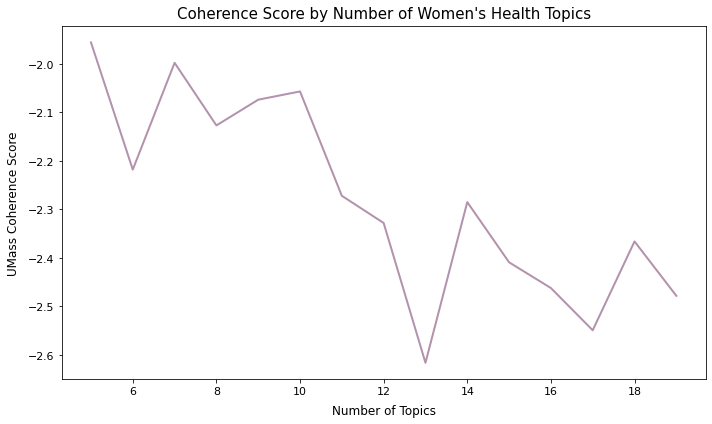

In [22]:
plot_coherence_by_topic(5, 20, 1, 
                        health_lda_coherence, 
                        size = (10,6), 
                        title = 'Coherence Score by Number of Women\'s Health Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

##### Examine Topic Composition for Each Number of Topics

Because each model that was built in the grid search was stored in a model dictionary where the number of topics was the key, we can easily access the model to explore the topics that were created. 

For example, for the model with 6 topics, the following code can be used to retrieve the top 10 terms for each of the 6 topics.

```python
health_lda_6 = health_lda_models[6]

get_topic_terms(health_lda_6, 6, 10)
```
This was done for each several numbers of topics. At each step of the way, the topic clusters were evaluated to determine if the clusters made sense and if any loss in cohesion was offset by a gain in knowledge about a woman's health concern. After this process, 15 topics was determined to be the optimal number of topics for the general women's health data. Therefore, a new model was fit with the identified number of topics. To ensure, optimal allocation of topics, the model was allowed to run for 100 iterations. 

#### Build a Final LDA model with topic number chosen from review of grid search

In [23]:
health_lda_model = build_gensim_lda(health_corpus, 
                               n_topics = 15, 
                               vocabulary = health_vocabulary, 
                               n_passes = 100)

In [24]:
# pickle.dump(health_lda_model, open('health_lda_model.p', 'wb'))

In [25]:
get_topic_terms(health_lda_model, 15, 10)

[(0,
  '0.028*"infection" + 0.026*"yeast" + 0.023*"yeast infection" + 0.017*"discharge" + 0.017*"uti" + 0.012*"bv" + 0.011*"antibiotic" + 0.009*"symptom" + 0.009*"smell" + 0.008*"doctor"'),
 (1,
  '0.020*"labia" + 0.018*"bump" + 0.014*"skin" + 0.014*"vagina" + 0.011*"area" + 0.010*"itchy" + 0.010*"notice" + 0.009*"pimple" + 0.009*"look" + 0.009*"red"'),
 (2,
  '0.017*"pap" + 0.014*"doctor" + 0.012*"smear" + 0.011*"appointment" + 0.011*"health" + 0.010*"pap smear" + 0.009*"hpv" + 0.008*"woman" + 0.008*"test" + 0.008*"exam"'),
 (3,
  '0.063*"hair" + 0.016*"shave" + 0.013*"look" + 0.012*"wax" + 0.011*"skin" + 0.011*"face" + 0.010*"makeup" + 0.009*"grow" + 0.008*"use" + 0.008*"try"'),
 (4,
  '0.033*"wear" + 0.024*"dress" + 0.015*"look" + 0.014*"buy" + 0.013*"clothe" + 0.011*"jean" + 0.009*"style" + 0.009*"shoe" + 0.009*"find" + 0.009*"fit"'),
 (5,
  '0.136*"conscious" + 0.129*"self conscious" + 0.118*"self" + 0.062*"good" + 0.047*"fake" + 0.034*"app" + 0.031*"travel" + 0.028*"deal" + 0.024

In [26]:
build_gensim_coherence_model(health_lda_model, corpus = health_corpus, dictionary = health_vocabulary)

-2.454

In [27]:
# pyLDAvis.gensim.prepare(df_lda_17, health_corpus, health_vocabulary)

#### Fertility and Pregnancy

In [ ]:
obsgyn_lda_models, obsgyn_lda_coherence = grid_search_lda(corpus = obsgyn_corpus, 
                                                          vocabulary = obsgyn_vocabulary, 
                                                          n_passes = 10, 
                                                          start = 2, 
                                                          stop = 30, 
                                                          step_size = 2)

Building LDA model for 2 topics


In [ ]:
plot_coherence_by_topic(2, 30, 2, 
                        obsgyn_lda_coherence, 
                        size = (10,6), 
                        title = 'Coherence Score by Number of Fertility and Pregnancy Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

In [ ]:
obsgyn_lda_model = build_gensim_lda(obsgyn_corpus, 
                               n_topics = 12, 
                               vocabulary = obsgyn_vocabulary, 
                               n_passes = 100)

In [ ]:
get_topic_terms(obsgyn_lda_model, 12, 10)

In [ ]:
build_gensim_coherence_model(obsgyn_lda_model, corpus = obsgyn_corpus, dictionary = obsgyn_vocabulary)

In [ ]:
# pickle.dump(obsgyn_lda_model, open('../pickles/obsgyn_lda_model.p', 'wb'))

#### Postpartum Data

In [ ]:
pospar_lda_models, pospar_lda_coherence = grid_search_lda(corpus = pospar_corpus, 
                                                          vocabulary = pospar_vocabulary, 
                                                          n_passes = 10, 
                                                          start = 2, 
                                                          stop = 30, 
                                                          step_size = 2)

In [ ]:
plot_coherence_by_topic(2, 30, 2, 
                        pospar_lda_coherence, 
                        size = (10,6), 
                        title = 'Coherence Score by Number of Pospartum/Early Parenthood Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

In [ ]:
pospar_lda_model = build_gensim_lda(pospar_corpus, 
                               n_topics = 22, 
                               vocabulary = pospar_vocabulary, 
                               n_passes = 100)

In [ ]:
get_topic_terms(pospar_lda_model, 22, 10)

In [ ]:
# pickle.dump(pospar_lda_model, open('../pickles/pospar_lda_model.p', 'wb'))